### Transformer

transformer with finance data

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
start_date = '2000-01-01'
end_date = '2024-03-18'
ticker = "^GSPC"
data = yf.download(ticker, start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [139]:
import torch
import math
import torch.nn.functional as F
from torch import nn

In [140]:
prices = data['Close'].values.reshape(-1, 1)

In [146]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
prices_scaled = scaler.fit_transform(prices)

def create_sequences(data, sequence_length=10):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [147]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=10):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        return (self.data[index:index+self.sequence_length],
                self.data[index+1:index+self.sequence_length+1])

data = prices_scaled.squeeze()
sequence_length = 20

dataset = TimeSeriesDataset(data, sequence_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [148]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim=1, model_dim=64, num_heads=2, num_layers=2, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(model_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_layers)
        self.encoder = nn.Linear(input_dim, model_dim)
        self.decoder = nn.Linear(model_dim, 1)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self.generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [156]:
from torch import optim
import warnings
warnings.filterwarnings('ignore')

model = TransformerTimeSeries()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [161]:
epochs = 100
for epoch in range(epochs):
    for src, tgt in dataloader:
        optimizer.zero_grad()
        src = src.float()
        tgt = tgt.float() 
        src = src.unsqueeze(-1)  # 입력 차원을 맞춤 (Batch, Seq, Features)
        tgt = tgt.unsqueeze(-1)
        output = model(src)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.11711302399635315
Epoch 2, Loss: 0.10779213905334473
Epoch 3, Loss: 0.09262920916080475
Epoch 4, Loss: 0.3008228540420532
Epoch 5, Loss: 0.2134229987859726
Epoch 6, Loss: 0.22623975574970245
Epoch 7, Loss: 0.21694274246692657
Epoch 8, Loss: 0.21176886558532715
Epoch 9, Loss: 0.18658359348773956
Epoch 10, Loss: 0.14363770186901093
Epoch 11, Loss: 0.05744021385908127
Epoch 12, Loss: 0.0537734217941761
Epoch 13, Loss: 0.12681064009666443
Epoch 14, Loss: 0.562420666217804
Epoch 15, Loss: 1.1589888334274292
Epoch 16, Loss: 1.28561270236969
Epoch 17, Loss: 1.3064574003219604


KeyboardInterrupt: 

In [162]:
model.eval()  # 모델을 평가 모드로 설정
total_loss = 0
with torch.no_grad():  # 그래디언트 계산을 비활성화
    for src, tgt in dataloader:
        src = src.float()
        tgt = tgt.float()
        
        src = src.unsqueeze(-1)  # 입력 차원을 맞춤 (Batch, Seq, Features)
        tgt = tgt.unsqueeze(-1)
        output = model(src)
        loss = criterion(output, tgt)
        total_loss += loss.item()

average_loss = total_loss / len(dataloader)
print(f'Test Loss: {average_loss}')

Test Loss: 0.2775007400168091


In [163]:
model.eval()

# 예측값과 실제값을 저장할 리스트 초기화
predictions = []
actuals = []

with torch.no_grad():
    for src, tgt in dataloader:
        src = src.float()
        src = src.unsqueeze(-1)  # 입력 차원을 맞춤 (Batch, Seq, Features)
        output = model(src)
        predictions.extend(output.view(-1).tolist())
        actuals.extend(tgt.view(-1).tolist())

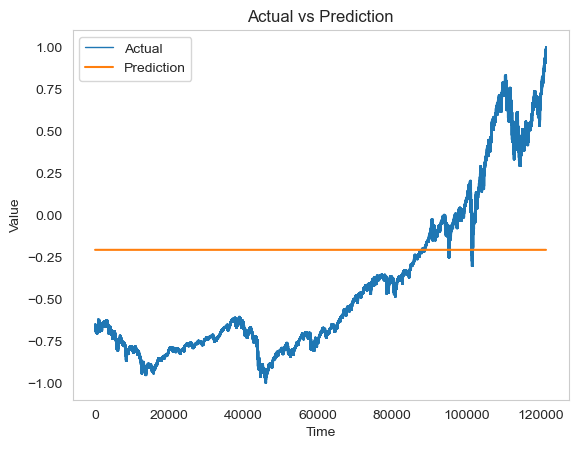

In [164]:
# 예측값과 실제값 시각화
plt.plot(actuals, label='Actual', lw = 1)
plt.plot(predictions, label='Prediction')
plt.title('Actual vs Prediction')
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()